In [1]:
# standard ds imports
import numpy as np
import pandas as pd

# for wrangling and exploration
import acquire
import prepare
import explore
import model

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# for statistical analysis
import scipy.stats as stats

# for model evaluation
import sklearn.metrics as met
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# DECISION TREE

### Titanic Dataset:

In [2]:
titanic = acquire.get_titanic_data()
titanic = prepare.prep_titanic(titanic)
train, val, test = prepare.split_data(titanic, 'survived')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534 entries, 455 to 496
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   passenger_id             534 non-null    int64  
 1   survived                 534 non-null    int64  
 2   pclass                   534 non-null    int64  
 3   sibsp                    534 non-null    int64  
 4   parch                    534 non-null    int64  
 5   fare                     534 non-null    float64
 6   alone                    534 non-null    int64  
 7   sex_male                 534 non-null    uint8  
 8   embark_town_Queenstown   534 non-null    uint8  
 9   embark_town_Southampton  534 non-null    uint8  
dtypes: float64(1), int64(6), uint8(3)
memory usage: 34.9 KB


#### 1. What is your baseline prediction? What is your baseline accuracy? remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). When you make those predictions, what is your accuracy? This is your baseline accuracy.

In [12]:
# baseline is 100% not surviving due to it being the mode for the survived feature
baseline = train.survived.mode()
baseline_train = baseline.tolist()*train.shape[0]
baseline_val = baseline.tolist()*val.shape[0]
baseline_test = baseline.tolist()*test.shape[0]

In [4]:
pd.DataFrame(met.classification_report(train.survived, baseline_train, output_dict=True))

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,accuracy,macro avg,weighted avg
precision,0.616105,0.0,0.616105,0.308052,0.379585
recall,1.000000,0.0,0.616105,0.500000,0.616105
f1-score,0.762457,0.0,0.616105,0.381228,0.469753
support,329.000000,205.0,0.616105,534.000000,534.000000


#### 2. Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)

In [5]:
y_train = train.survived
X_train = train.drop(columns=['survived', 'passenger_id'])
X_train.shape, y_train.shape

((534, 8), (534,))

In [6]:
X_val = val.drop(columns=['survived','passenger_id'])
y_val = val.survived
X_test = test.drop(columns=['survived','passenger_id'])
y_test = test.survived

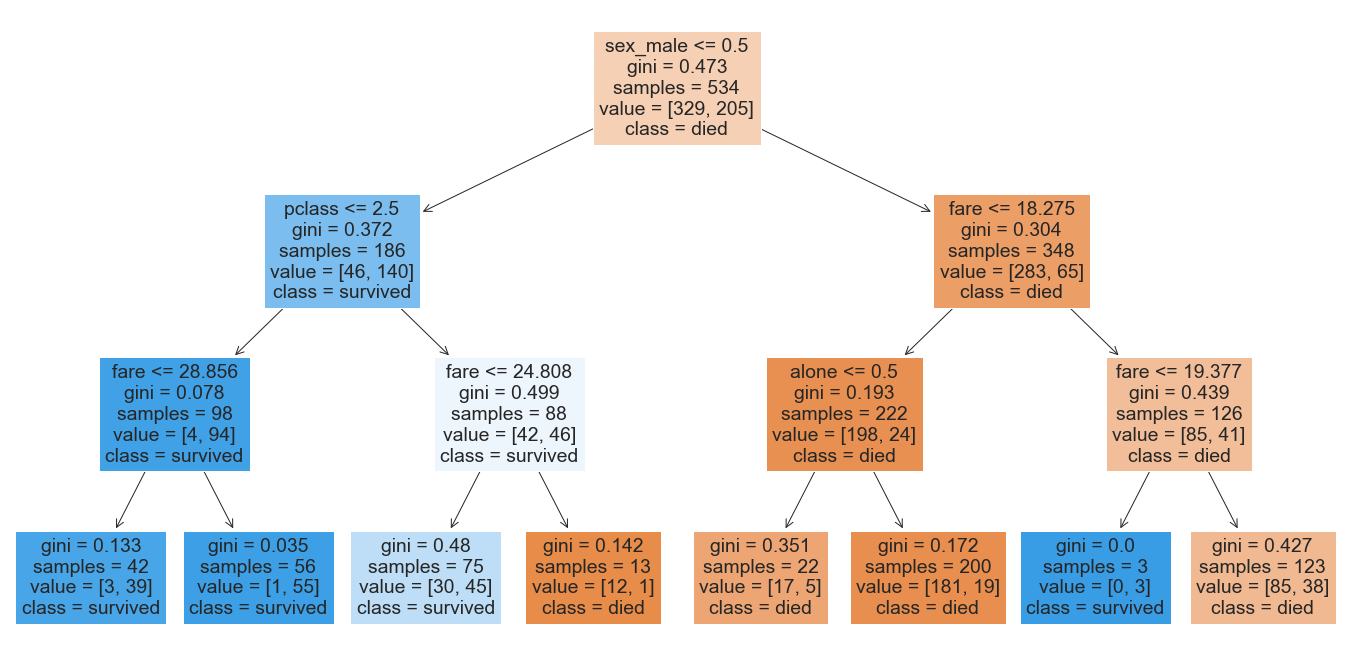

In [7]:
model1 = DecisionTreeClassifier(max_depth=3)
model1.fit(X_train, y_train)
plt.figure(figsize=(24,12))
plot_tree(model1, feature_names=X_train.columns.to_list(), class_names=['died','survived'], rounded=False, filled=True)
plt.show()

#### 3. Evaluate your in-sample results using the model score, confusion matrix, and classification report.

In [8]:
print(f'training score: {model1.score(X_train, y_train):.2%}')

training score: 81.84%


In [9]:
cm = met.confusion_matrix(train.survived, model1.predict(X_train))
cm

array([[295,  34],
       [ 63, 142]])

In [52]:
rubric = pd.DataFrame({
    'pred_death' : ['True Neg', 'False Neg'], 
    'pred_survive' : ['False Pos', 'True Pos']
    }, index=['actual_death', 'actual_survive'])

rubric

,pred_death,pred_survive
actual_death,True Neg,False Pos
actual_survive,False Neg,True Pos


In [53]:
rubric + ': ' + cm.astype(str)

,pred_death,pred_survive
actual_death,True Neg: 295,False Pos: 34
actual_survive,False Neg: 63,True Pos: 142


In [54]:
pd.DataFrame(met.classification_report(train.survived, model1.predict(X_train), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.824022,0.806818,0.818352,0.815420,0.817418
recall,0.896657,0.692683,0.818352,0.794670,0.818352
f1-score,0.858806,0.745407,0.818352,0.802107,0.815273
support,329.000000,205.000000,0.818352,534.000000,534.000000


#### 4. Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [55]:
TP = cm[1,1]
FP = cm[0,1]
TN = cm[0,0]
FN = cm[1,0]

print(f'accuracy: {(TP+TN)/(TP+FP+FN+TN):.2%}')
print(f'true positive rate / recall: {TP/(TP+FN):.2%}')
print(f'true negative rate / Specificity: {(TN)/(FP+TN):.2%}')
print(f'false potivie rate: {FP / (FP + TN):.2%}')
print(f'false negative rate: {(FN)/(TN+FN):.2%}')
print(f'Percision: {TP/(TP+FP):.2%}')
print(f'f1-score: {met.f1_score(train.survived, model1.predict(X_train)):.2%}')
print(f'support pos: {TP + FN}')
print(f'support neg: {FP + TN}')

accuracy: 81.84%
true positive rate / recall: 69.27%
true negative rate / Specificity: 89.67%
false potivie rate: 10.33%
false negative rate: 17.60%
Percision: 80.68%
f1-score: 74.54%
support pos: 205
support neg: 329


In [56]:
# ON THE WAY TO MAKE IT MORE MODULAR
def binary_decisiontree_data(train, X_train, y_train, target):
    '''
    ONLY FOR A BINARY TARGET. 
    
    This function takes in:
        train = train dataset as DataFrame
        X_train = train dataset minus target series as DataFrame
        y_train = target variable column as a series
        target = target variable as a string
        
    Returns a DataFrame running decision tree models from 2 to 7 depth with confusion matrix data.
    '''
    models = {}
    z = 1
    for i in range(2,8):
        model = DecisionTreeClassifier(max_depth=i)
        model.fit(X_train, y_train)

        cm = met.confusion_matrix(train[target], model.predict(X_train))
        TP = cm[1,1]
        FP = cm[0,1]
        TN = cm[0,0]
        FN = cm[1,0]

        acc = round(((TP+TN)/(TP+FP+FN+TN))*100,2)
        TPR = round((TP/(TP+FN))*100,2)
        TNR = round(((TN)/(FP+TN))*100,2)
        FPR = round((FP / (FP + TN))*100,2)
        FNR = round(((FN)/(TN+FN))*100,2)
        percision = round((TP/(TP+FP))*100,2)
        f1 = round((met.f1_score(train[target], model1.predict(X_train)))*100,2)
        sp = TP + FN
        sn = FP + TN

        model_name = 'model '+str(z)
        models[model_name] = {'Accuracy' : acc.astype(str)+'%', 
                         'Recall TPR': TPR.astype(str)+'%', 
                         'Specificity TNR': TNR.astype(str)+'%', 
                         'FPR': FPR.astype(str)+'%', 
                         'FNR': FNR.astype(str)+'%', 
                         'Percision': percision.astype(str)+'%',
                         'F1-score': f1.astype(str)+'%',
                         'Support pos': sp,
                         'Support neg': sn}
        z+=1
    return pd.DataFrame(models).T

In [57]:
binary_decisiontree_data(train, X_train, y_train, 'survived')

,Accuracy,Recall TPR,Specificity TNR,FPR,FNR,Percision,F1-score,Support pos,Support neg
model 1,79.21%,68.29%,86.02%,13.98%,18.68%,75.27%,74.54%,205,329
model 2,81.84%,69.27%,89.67%,10.33%,17.6%,80.68%,74.54%,205,329
model 3,82.02%,69.27%,89.97%,10.03%,17.55%,81.14%,74.54%,205,329
model 4,83.33%,60.0%,97.87%,2.13%,20.3%,94.62%,74.54%,205,329
model 5,85.96%,67.32%,97.57%,2.43%,17.27%,94.52%,74.54%,205,329
model 6,86.33%,67.8%,97.87%,2.13%,17.01%,95.21%,74.54%,205,329


#### 5. Run through steps 2-4 using a different max_depth value.

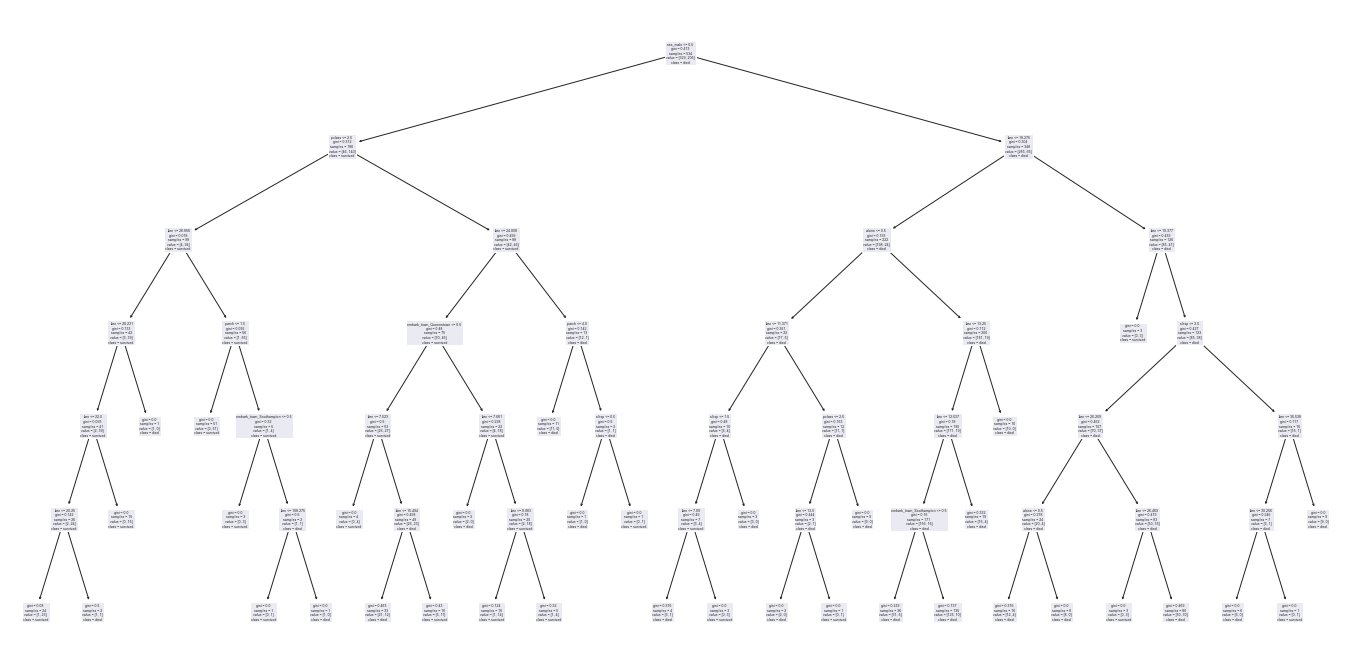

In [58]:
model2 = DecisionTreeClassifier(max_depth=6)
model2.fit(X_train, y_train)
plt.figure(figsize=(24,12))
plot_tree(model2, feature_names=X_train.columns.to_list(), class_names=['died','survived'])
plt.show()

In [59]:
print(f'training score: {model2.score(X_train, y_train):.2%}')

training score: 85.96%


In [60]:
pd.DataFrame(met.classification_report(train.survived, model2.predict(X_train), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.827320,0.945205,0.859551,0.886263,0.872575
recall,0.975684,0.673171,0.859551,0.824427,0.859551
f1-score,0.895397,0.786325,0.859551,0.840861,0.853525
support,329.000000,205.000000,0.859551,534.000000,534.000000


In [61]:
TP = ((train.survived == 1) & (model2.predict(X_train) == 1)).sum()
FP = ((train.survived == 0) & (model2.predict(X_train) == 1)).sum()
TN = ((train.survived == 0) & (model2.predict(X_train) == 0)).sum()
FN = ((train.survived == 1) & (model2.predict(X_train) == 0)).sum()

print(f'accuracy: {met.accuracy_score(train.survived, model2.predict(X_train)):.2%}')
print(f'true positive rate / recall: {met.recall_score(train.survived, model2.predict(X_train)):.2%}')
print(f'true negative rate / Specificity: {(TN)/(FP+TN):.2%}')
print(f'false potivie rate / Percision: {met.precision_score(train.survived, model2.predict(X_train)):.2%}')
print(f'false negative rate: {(TN)/(TN+FN):.2%}')
print(f'f1-score: {met.f1_score(train.survived, model2.predict(X_train)):.2%}')
print(f'support: {model2.predict(X_train).sum()}')

accuracy: 85.96%
true positive rate / recall: 67.32%
true negative rate / Specificity: 97.57%
false potivie rate / Percision: 94.52%
false negative rate: 82.73%
f1-score: 78.63%
support: 146


#### 6. Which model performs better on your in-sample data?

In [62]:
print(f'Model 1 Accuracy: {met.accuracy_score(train.survived, model1.predict(X_train)):.2%}')
print(f'Model 2 Accuracy: {met.accuracy_score(train.survived, model2.predict(X_train)):.2%}')
print(f'Baseline Accuracy: {met.accuracy_score(train.survived, baseline_train):.2%}')

Model 1 Accuracy: 81.84%
Model 2 Accuracy: 85.96%
Baseline Accuracy: 61.61%


In [63]:
# Model 2 performs better on the train dataset

#### 7. Which model performs best on your out-of-sample data, the validate set?

In [64]:
print(f'Model 1 Accuracy: {met.accuracy_score(val.survived, model1.predict(X_val)):.2%}')
print(f'Model 2 Accuracy: {met.accuracy_score(val.survived, model2.predict(X_val)):.2%}')
print(f'Baseline Accuracy: {met.accuracy_score(val.survived, baseline_val):.2%}')

Model 1 Accuracy: 79.21%
Model 2 Accuracy: 77.53%
Baseline Accuracy: 61.80%


In [65]:
# Model 1 perfoms better on the validate dataset

<AxesSubplot:ylabel='Feature Importance'>

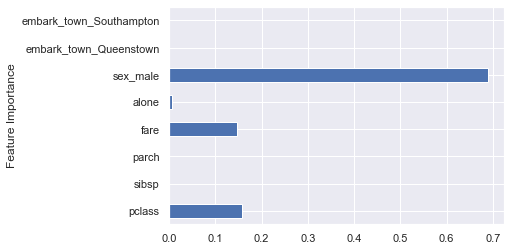

In [66]:
pd.Series(dict(zip(X_train.columns, model1.feature_importances_))).plot.barh(xlabel='Feature Importance')

<AxesSubplot:ylabel='Feature Importance'>

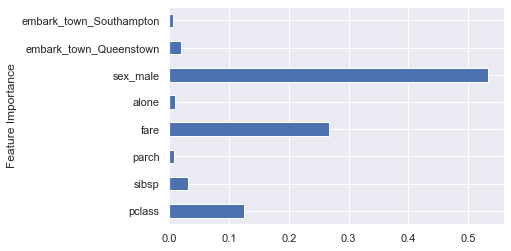

In [67]:
pd.Series(dict(zip(X_train.columns, model2.feature_importances_))).plot.barh(xlabel='Feature Importance')

In [68]:
# Gender, fare, and class are the top 3 features when determining survival

### Telco Dataset:

In [27]:
telco = acquire.get_telco_data()
telco = prepare.prep_telco(telco)
train, val, test = prepare.split_data(telco, 'churn_Yes')

In [28]:
train.head()

,customer_id,senior_citizen,tenure,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,...,churn_Yes,Month-to-month,One year,Two year,DSL,Fiber optic,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
5911,8319-QBEHW,0,26,0,0,1,0,0,1,0,...,0,0,1,0,1,0,1,0,0,0
2479,3547-LQRIK,0,47,2,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
5889,8280-MQRQN,0,1,1,0,0,1,0,0,0,...,1,1,0,0,1,0,0,0,0,1
6087,8626-PTQGE,0,69,0,1,1,0,1,1,1,...,0,0,0,1,1,0,1,0,0,0
785,1142-IHLOO,0,51,1,0,0,0,0,1,1,...,0,0,1,0,0,1,0,1,0,0


#### 1. What is your baseline prediction? What is your baseline accuracy? remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). When you make those predictions, what is your accuracy? This is your baseline accuracy.

In [29]:
baseline = train.churn_Yes.mode()
baseline_train = baseline.tolist()*train.shape[0]
baseline_val = baseline.tolist()*val.shape[0]
baseline_test = baseline.tolist()*test.shape[0]
pd.DataFrame(met.classification_report(train.churn_Yes, baseline_train, output_dict=True))

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,accuracy,macro avg,weighted avg
precision,0.734675,0.0,0.734675,0.367337,0.539747
recall,1.000000,0.0,0.734675,0.500000,0.734675
f1-score,0.847046,0.0,0.734675,0.423523,0.622303
support,3104.000000,1121.0,0.734675,4225.000000,4225.000000


#### 2. Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)

In [30]:
X_train = train.drop(columns=['churn_Yes', 'customer_id'])
y_train = train.churn_Yes
X_val = val.drop(columns=['churn_Yes', 'customer_id'])
y_val = val.churn_Yes
X_test = test.drop(columns=['churn_Yes', 'customer_id'])
y_test = test.churn_Yes

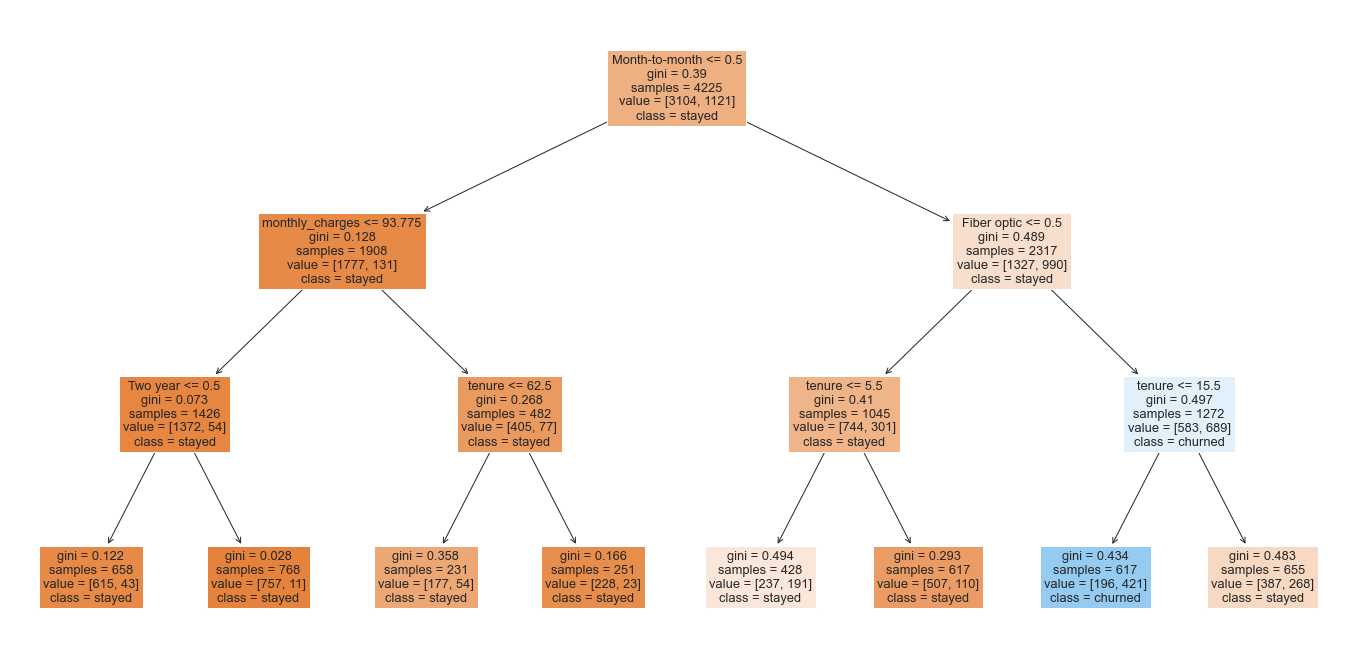

In [31]:
model1 = DecisionTreeClassifier(max_depth=3)
model1.fit(X_train, y_train)
plt.figure(figsize=(24,12))
plot_tree(model1, feature_names=X_train.columns.to_list(), class_names=['stayed','churned'], filled=True)
plt.show()

#### 3. Evaluate your in-sample results using the model score, confusion matrix, and classification report.

In [32]:
model1.score(X_train, y_train)

0.7879289940828402

In [33]:
pd.DataFrame(met.classification_report(train.churn_Yes, model1.predict(X_train), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.805987,0.682334,0.787929,0.744160,0.773178
recall,0.936856,0.375558,0.787929,0.656207,0.787929
f1-score,0.866508,0.484465,0.787929,0.675486,0.765142
support,3104.000000,1121.000000,0.787929,4225.000000,4225.000000


#### 4. Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [34]:
TP = ((train.churn_Yes == 1) & (model1.predict(X_train) == 1)).sum()
FP = ((train.churn_Yes == 0) & (model1.predict(X_train) == 1)).sum()
TN = ((train.churn_Yes == 0) & (model1.predict(X_train) == 0)).sum()
FN = ((train.churn_Yes == 1) & (model1.predict(X_train) == 0)).sum()

print(f'accuracy: {met.accuracy_score(train.churn_Yes, model1.predict(X_train)):.2%}')
print(f'true positive rate / recall: {met.recall_score(train.churn_Yes, model1.predict(X_train)):.2%}')
print(f'true negative rate / Specificity: {(TN)/(FP+TN):.2%}')
print(f'false potivie rate / Percision: {met.precision_score(train.churn_Yes, model1.predict(X_train)):.2%}')
print(f'false negative rate: {(TN)/(TN+FN):.2%}')
print(f'f1-score: {met.f1_score(train.churn_Yes, model1.predict(X_train)):.2%}')
print(f'support: {model1.predict(X_train).sum()}')

accuracy: 78.79%
true positive rate / recall: 37.56%
true negative rate / Specificity: 93.69%
false potivie rate / Percision: 68.23%
false negative rate: 80.60%
f1-score: 48.45%
support: 617


#### 5. Run through steps 2-4 using a different max_depth value.

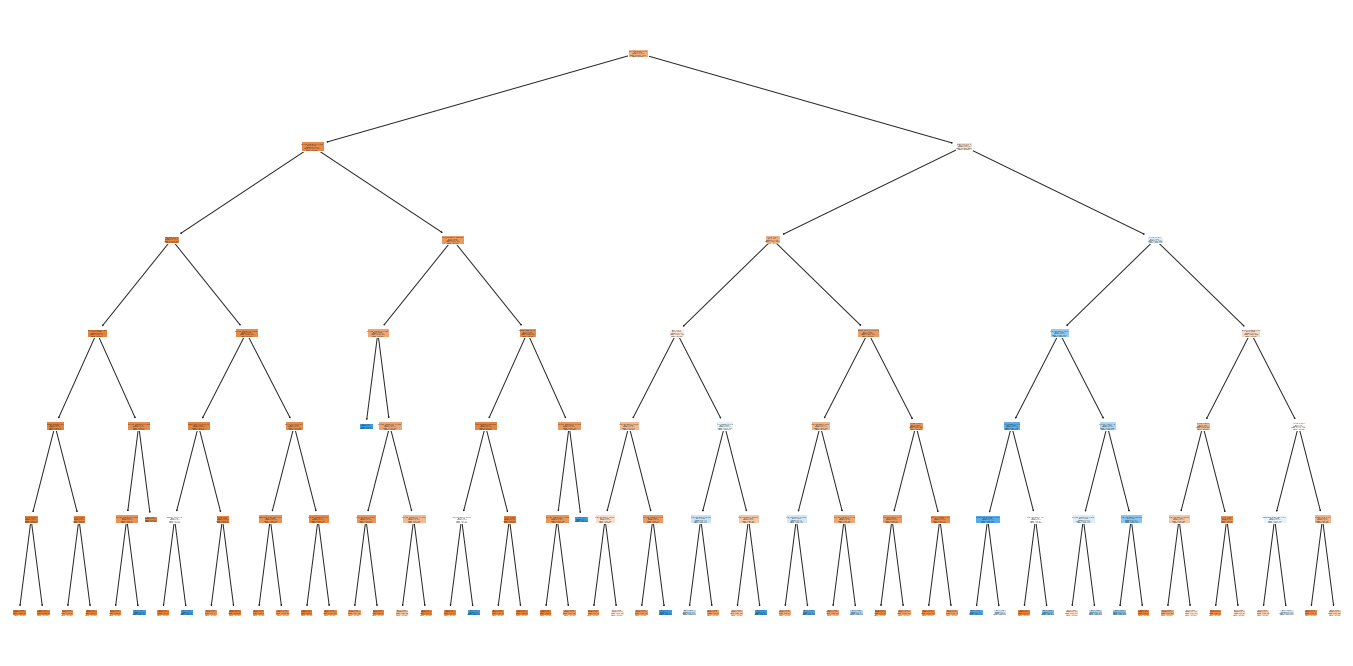

In [35]:
model2 = DecisionTreeClassifier(max_depth=6)
model2.fit(X_train, y_train)
plt.figure(figsize=(24,12))
plot_tree(model2, feature_names=X_train.columns.to_list(), class_names=['stayed','churned'], filled=True)
plt.show()

In [36]:
pd.DataFrame(met.classification_report(train.churn_Yes, model2.predict(X_train), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.856440,0.672840,0.814201,0.764640,0.807726
recall,0.897552,0.583408,0.814201,0.740480,0.814201
f1-score,0.876514,0.624940,0.814201,0.750727,0.809765
support,3104.000000,1121.000000,0.814201,4225.000000,4225.000000


In [37]:
TP = ((train.churn_Yes == 1) & (model1.predict(X_train) == 1)).sum()
FP = ((train.churn_Yes == 0) & (model1.predict(X_train) == 1)).sum()
TN = ((train.churn_Yes == 0) & (model1.predict(X_train) == 0)).sum()
FN = ((train.churn_Yes == 1) & (model1.predict(X_train) == 0)).sum()

print(f'accuracy: {met.accuracy_score(train.churn_Yes, model1.predict(X_train)):.2%}')
print(f'true positive rate / recall: {met.recall_score(train.churn_Yes, model1.predict(X_train)):.2%}')
print(f'true negative rate / Specificity: {(TN)/(FP+TN):.2%}')
print(f'false potivie rate / Percision: {met.precision_score(train.churn_Yes, model1.predict(X_train)):.2%}')
print(f'false negative rate: {(TN)/(TN+FN):.2%}')
print(f'f1-score: {met.f1_score(train.churn_Yes, model1.predict(X_train)):.2%}')
print(f'support: {model1.predict(X_train).sum()}')

accuracy: 78.79%
true positive rate / recall: 37.56%
true negative rate / Specificity: 93.69%
false potivie rate / Percision: 68.23%
false negative rate: 80.60%
f1-score: 48.45%
support: 617


#### 6. Which model performs better on your in-sample data?

In [38]:
print(f'Model 1 Accuracy: {met.accuracy_score(train.churn_Yes, model1.predict(X_train)):.2%}')
print(f'Model 2 Accuracy: {met.accuracy_score(train.churn_Yes, model2.predict(X_train)):.2%}')
print(f'Baseline Accuracy: {met.accuracy_score(train.churn_Yes, baseline_train):.2%}')

Model 1 Accuracy: 78.79%
Model 2 Accuracy: 81.42%
Baseline Accuracy: 73.47%


In [39]:
# Model 2 performs better with train dataset

#### 7. Which model performs best on your out-of-sample data, the validate set?

In [40]:
print(f'Model 1 Accuracy: {met.accuracy_score(val.churn_Yes, model1.predict(X_val)):.2%}')
print(f'Model 2 Accuracy: {met.accuracy_score(val.churn_Yes, model2.predict(X_val)):.2%}')
print(f'Baseline Accuracy: {met.accuracy_score(val.churn_Yes, baseline_val):.2%}')

Model 1 Accuracy: 79.28%
Model 2 Accuracy: 79.84%
Baseline Accuracy: 73.46%


In [41]:
# Model 2 performs better with validate dataset

<AxesSubplot:ylabel='Feature Importance'>

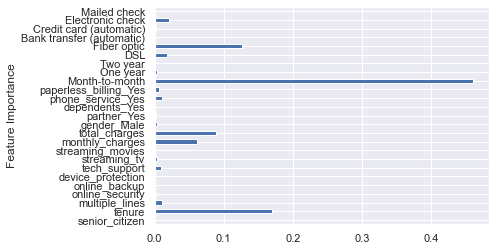

In [42]:
pd.Series(dict(zip(X_train.columns, model2.feature_importances_))).plot.barh(xlabel='Feature Importance')

In [43]:
# Fiber optic, month-to-month contracts, and tenure are the top 3 features when determining churn

# RANDOM FOREST

In [2]:
titanic = acquire.get_titanic_data()
titanic = prepare.prep_titanic(titanic)
train, val, test = prepare.split_data(titanic, 'survived')
train.head()

,passenger_id,survived,pclass,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
455,455,1,3,0,0,7.8958,1,1,0,0
380,380,1,1,0,0,227.5250,1,0,0,0
492,492,0,1,0,0,30.5000,1,1,0,1
55,55,1,1,0,0,35.5000,1,1,0,1
243,243,0,3,0,0,7.1250,1,1,0,1


In [3]:
y_train = train.survived
X_train = train.drop(columns=['survived', 'passenger_id', 'sibsp', 'parch', 'embark_town_Queenstown','embark_town_Southampton'])
X_val = val.drop(columns=['survived','passenger_id', 'sibsp', 'parch', 'embark_town_Queenstown','embark_town_Southampton'])
y_val = val.survived
X_test = test.drop(columns=['survived','passenger_id', 'sibsp', 'parch', 'embark_town_Queenstown','embark_town_Southampton'])
y_test = test.survived

#### 1. Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

In [4]:
rf1 = RandomForestClassifier(max_depth=10, min_samples_leaf=1, random_state=123)
rf1.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=123)

#### 2. Evaluate your results using the model score, confusion matrix, and classification report.

In [5]:
rf1.score(X_train, y_train)

0.9325842696629213

In [6]:
pd.DataFrame(met.classification_report(train.survived, rf1.predict(X_train), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.917379,0.961749,0.932584,0.939564,0.934412
recall,0.978723,0.858537,0.932584,0.918630,0.932584
f1-score,0.947059,0.907216,0.932584,0.927138,0.931764
support,329.000000,205.000000,0.932584,534.000000,534.000000


In [7]:
met.confusion_matrix(train.survived, rf1.predict(X_train))

array([[322,   7],
       [ 29, 176]])

#### 3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [8]:
cm = met.confusion_matrix(train['survived'], rf1.predict(X_train))
TP = cm[1,1]
FP = cm[0,1]
TN = cm[0,0]
FN = cm[1,0]
acc = round(((TP+TN)/(TP+FP+FN+TN))*100,2)
TPR = round((TP/(TP+FN))*100,2)
TNR = round(((TN)/(FP+TN))*100,2)
FPR = round((FP / (FP + TN))*100,2)
FNR = round(((FN)/(TN+FN))*100,2)
percision = round((TP/(TP+FP))*100,2)
f1 = round((met.f1_score(train['survived'], rf1.predict(X_train)))*100,2)
sp = TP + FN
sn = FP + TN
models = {}
models['rf1'] = {'Accuracy' : acc.astype(str)+'%', 
                 'Recall TPR': TPR.astype(str)+'%', 
                 'Specificity TNR': TNR.astype(str)+'%', 
                 'FPR': FPR.astype(str)+'%', 
                 'FNR': FNR.astype(str)+'%', 
                 'Percision': percision.astype(str)+'%',
                 'F1-score': f1.astype(str)+'%',
                 'Support pos': sp,
                 'Support neg': sn}

In [9]:
pd.DataFrame(models)

,rf1
Accuracy,93.26%
F1-score,90.72%
FNR,8.26%
FPR,2.13%
Percision,96.17%
Recall TPR,85.85%
Specificity TNR,97.87%
Support neg,329
Support pos,205


#### 4. Run through steps increasing your min_samples_leaf and decreasing your max_depth.

In [10]:
# def binary_randomforest_data(train, X_train, y_train, target):
#     '''
#     ONLY FOR A BINARY TARGET. 
    
#     This function takes in:
#         train = train dataset as DataFrame
#         X_train = train dataset minus target series as DataFrame
#         y_train = target variable column as a series
#         target = target variable as a string
        
#     Returns a DataFrame running random forest models with confusion matrix data
#     from 2 to 9 depth and 1 to 4 min sample leaf.
#     '''
#     models = {}
#     z = 1
#     for i in range(2,10):
#         for x in range(1,5):
#             model = RandomForestClassifier(max_depth=i, min_samples_leaf=x)
#             model.fit(X_train, y_train)
    
#             cm = met.confusion_matrix(train[target], model.predict(X_train))
#             TP = cm[1,1]
#             FP = cm[0,1]
#             TN = cm[0,0]
#             FN = cm[1,0]
    
#             acc = round(((TP+TN)/(TP+FP+FN+TN))*100,2)
#             TPR = round((TP/(TP+FN))*100,2)
#             TNR = round(((TN)/(FP+TN))*100,2)
#             FPR = round((FP / (FP + TN))*100,2)
#             FNR = round(((FN)/(TN+FN))*100,2)
#             percision = round((TP/(TP+FP))*100,2)
#             f1 = round((met.f1_score(train[target], model1.predict(X_train)))*100,2)
#             sp = TP + FN
#             sn = FP + TN
            
#             model_name = 'model' + str(z)
#             models[model_name] = {'Max Depth' : i,
#                          'Min Samples Leaf' : x,
#                          'Accuracy' : acc.astype(str)+'%', 
#                          'Recall TPR': TPR.astype(str)+'%', 
#                          'Specificity TNR': TNR.astype(str)+'%', 
#                          'FPR': FPR.astype(str)+'%', 
#                          'FNR': FNR.astype(str)+'%', 
#                          'Percision': percision.astype(str)+'%',
#                          'F1-score': f1.astype(str)+'%',
#                          'Support pos': sp,
#                          'Support neg': sn}
#             z += 1
#     return pd.DataFrame(models).T

In [11]:
# ^^^^^ created model.py instead

In [12]:
# Different depths

In [13]:
rf_train_data = model.binary_randomforest_data(train, X_train, y_train, 'survived')

#### 5. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

In [14]:
rf_train_data

,max_depth,min_samples_leaf,accuracy,recall_TPR,specificity_TNR,FPR,FNR,percision,f1,support_pos,support_neg
model 1,2,1,77.72%,56.59%,90.88%,9.12%,22.94%,79.45%,66.1%,205,329
model 2,2,2,77.72%,56.59%,90.88%,9.12%,22.94%,79.45%,66.1%,205,329
model 3,2,3,77.72%,56.59%,90.88%,9.12%,22.94%,79.45%,66.1%,205,329
model 4,2,4,77.72%,56.59%,90.88%,9.12%,22.94%,79.45%,66.1%,205,329
model 5,3,1,81.27%,66.34%,90.58%,9.42%,18.8%,81.44%,73.12%,205,329
model 6,3,2,81.27%,66.34%,90.58%,9.42%,18.8%,81.44%,73.12%,205,329
model 7,3,3,81.27%,66.34%,90.58%,9.42%,18.8%,81.44%,73.12%,205,329
model 8,3,4,81.27%,66.34%,90.58%,9.42%,18.8%,81.44%,73.12%,205,329
model 9,4,1,83.9%,69.27%,93.01%,6.99%,17.07%,86.06%,76.76%,205,329
model 10,4,2,84.46%,68.29%,94.53%,5.47%,17.29%,88.61%,77.13%,205,329


In [15]:
rf_train_data[rf_train_data.accuracy == rf_train_data.accuracy.max()]

,max_depth,min_samples_leaf,accuracy,recall_TPR,specificity_TNR,FPR,FNR,percision,f1,support_pos,support_neg
model 29,9,1,92.88%,85.37%,97.57%,2.43%,8.55%,95.63%,90.21%,205,329


#### After making a few models, which one has the best performance (or closest metrics) on both train and validate?

In [16]:
rf_train_data[rf_train_data['recall_TPR'] == rf_train_data['recall_TPR'].max()]

,max_depth,min_samples_leaf,accuracy,recall_TPR,specificity_TNR,FPR,FNR,percision,f1,support_pos,support_neg
model 29,9,1,92.88%,85.37%,97.57%,2.43%,8.55%,95.63%,90.21%,205,329


In [17]:
rf_train_data[rf_train_data['specificity_TNR'] == rf_train_data['specificity_TNR'].max()]

,max_depth,min_samples_leaf,accuracy,recall_TPR,specificity_TNR,FPR,FNR,percision,f1,support_pos,support_neg
model 29,9,1,92.88%,85.37%,97.57%,2.43%,8.55%,95.63%,90.21%,205,329


In [18]:
# The minimum number of samples leafs and the maximum depth will always perform best because it is overfitting the dataset.

#### After making a few models, which one has the best performance (or closest metrics) on both train and validate?

In [19]:
rf_val_data = model.binary_randomforest_data(val, X_val, y_val, 'survived')

In [20]:
compare = pd.DataFrame({'depth': rf_train_data['max_depth'], 'min_sample_leaf':rf_train_data['min_samples_leaf'], 'train': rf_train_data.accuracy, 'validate': rf_val_data.accuracy})
compare.head()

,depth,min_sample_leaf,train,validate
model 1,2,1,77.72%,76.97%
model 2,2,2,77.72%,76.4%
model 3,2,3,77.72%,76.4%
model 4,2,4,77.72%,76.4%
model 5,3,1,81.27%,80.9%


In [21]:
compare.train = compare.train.str.replace('%','').astype(float)
compare.validate = compare.validate.str.replace('%','').astype(float)

In [22]:
compare[(compare.train > 90) & (compare.validate > 90)]

,depth,min_sample_leaf,train,validate
model 21,7,1,90.64,91.01
model 25,8,1,91.95,92.13
model 29,9,1,92.88,92.13


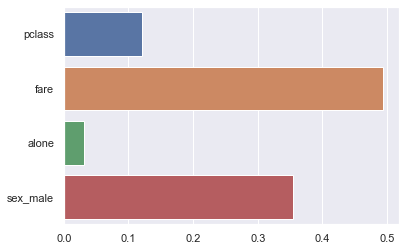

In [23]:
best_rf = RandomForestClassifier(max_depth=9, min_samples_leaf=1, random_state=123)
best_rf.fit(X_train, y_train)
sns.barplot(y=X_train.columns, x=best_rf.feature_importances_)
plt.show()

In [24]:
X_train.head()

,pclass,fare,alone,sex_male
455,3,7.8958,1,1
380,1,227.5250,1,0
492,1,30.5000,1,1
55,1,35.5000,1,1
243,3,7.1250,1,1


# KNN

In [3]:
titanic = acquire.get_titanic_data()
titanic = prepare.prep_titanic(titanic)
train, val, test = prepare.split_data(titanic, 'survived')
y_train = train.survived
X_train = train.drop(columns=['survived', 'passenger_id', 'sibsp', 'parch', 'embark_town_Queenstown','embark_town_Southampton'])
X_val = val.drop(columns=['survived','passenger_id', 'sibsp', 'parch', 'embark_town_Queenstown','embark_town_Southampton'])
y_val = val.survived
X_test = test.drop(columns=['survived','passenger_id', 'sibsp', 'parch', 'embark_town_Queenstown','embark_town_Southampton'])
y_test = test.survived

#### 1. Fit a K-Nearest Neighbors classifier to your training sample and transform (i.e. make predictions on the training sample)

In [3]:
knn1 = KNeighborsClassifier()
knn1.fit(X_train, y_train)

KNeighborsClassifier()

#### 2. Evaluate your results using the model score, confusion matrix, and classification report.

In [4]:
knn1.score(X_train, y_train)

0.8127340823970037

In [6]:
cm = met.confusion_matrix(y_train, knn1.predict(X_train))
cm

array([[279,  50],
       [ 50, 155]])

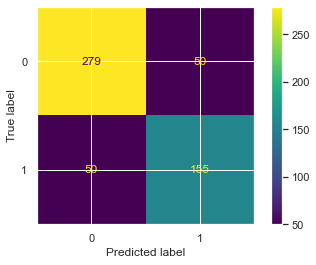

In [10]:
disp = met.ConfusionMatrixDisplay(cm, display_labels=knn1.classes_)
disp.plot()
plt.show()

In [11]:
pd.DataFrame(met.classification_report(y_train, knn1.predict(X_train), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.848024,0.756098,0.812734,0.802061,0.812734
recall,0.848024,0.756098,0.812734,0.802061,0.812734
f1-score,0.848024,0.756098,0.812734,0.802061,0.812734
support,329.000000,205.000000,0.812734,534.000000,534.000000


#### 3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [12]:
cm = met.confusion_matrix(y_train, knn1.predict(X_train))
TP = cm[1,1]
FP = cm[0,1]
TN = cm[0,0]
FN = cm[1,0]

acc = round(((TP+TN)/(TP+FP+FN+TN))*100,2)
TPR = round((TP/(TP+FN))*100,2)
TNR = round(((TN)/(FP+TN))*100,2)
FPR = round((FP / (FP + TN))*100,2)
FNR = round(((FN)/(TN+FN))*100,2)
percision = round((TP/(TP+FP))*100,2)
f1 = round((met.f1_score(y_train, knn1.predict(X_train)))*100,2)
sp = TP + FN
sn = FP + TN

models = {}
models[knn1] = {'accuracy' : acc.astype(str)+'%', 
                'recall_tpr': TPR.astype(str)+'%', 
                'specificity_tnr': TNR.astype(str)+'%', 
                'fpr': FPR.astype(str)+'%', 
                'fnr': FNR.astype(str)+'%', 
                'percision': percision.astype(str)+'%',
                'f1': f1.astype(str)+'%',
                'support_pos': sp,
                'support_neg': sn}

pd.DataFrame(models)

,KNeighborsClassifier()
accuracy,81.27%
f1,75.61%
fnr,15.2%
fpr,15.2%
percision,75.61%
recall_tpr,75.61%
specificity_tnr,84.8%
support_neg,329
support_pos,205


#### 4. Run through steps 2-4 setting k to 10

In [13]:
knn2 = KNeighborsClassifier(n_neighbors=10)
knn2.fit(X_train, y_train)
knn2.score(X_train, y_train)

0.7865168539325843

In [14]:
met.confusion_matrix(y_train, knn2.predict(X_train))

array([[282,  47],
       [ 67, 138]])

In [15]:
pd.DataFrame(met.classification_report(y_train, knn2.predict(X_train), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.808023,0.745946,0.786517,0.776984,0.784192
recall,0.857143,0.673171,0.786517,0.765157,0.786517
f1-score,0.831858,0.707692,0.786517,0.769775,0.784192
support,329.000000,205.000000,0.786517,534.000000,534.000000


In [16]:
cm = met.confusion_matrix(y_train, knn2.predict(X_train))
TP = cm[1,1]
FP = cm[0,1]
TN = cm[0,0]
FN = cm[1,0]

acc = round(((TP+TN)/(TP+FP+FN+TN))*100,2)
TPR = round((TP/(TP+FN))*100,2)
TNR = round(((TN)/(FP+TN))*100,2)
FPR = round((FP / (FP + TN))*100,2)
FNR = round(((FN)/(TN+FN))*100,2)
percision = round((TP/(TP+FP))*100,2)
f1 = round((met.f1_score(y_train, knn2.predict(X_train)))*100,2)
sp = TP + FN
sn = FP + TN

models = {}
models[knn1] = {'accuracy' : acc.astype(str)+'%', 
                'recall_tpr': TPR.astype(str)+'%', 
                'specificity_tnr': TNR.astype(str)+'%', 
                'fpr': FPR.astype(str)+'%', 
                'fnr': FNR.astype(str)+'%', 
                'percision': percision.astype(str)+'%',
                'f1': f1.astype(str)+'%',
                'support_pos': sp,
                'support_neg': sn}

pd.DataFrame(models)

,KNeighborsClassifier()
accuracy,78.65%
f1,70.77%
fnr,19.2%
fpr,14.29%
percision,74.59%
recall_tpr,67.32%
specificity_tnr,85.71%
support_neg,329
support_pos,205


#### 5. Run through setps 2-4 setting k to 20

In [17]:
knn3 = KNeighborsClassifier(n_neighbors=20)
knn3.fit(X_train, y_train)
knn3.score(X_train, y_train)

0.7490636704119851

In [18]:
met.confusion_matrix(y_train, knn3.predict(X_train))

array([[279,  50],
       [ 84, 121]])

In [19]:
pd.DataFrame(met.classification_report(y_train, knn3.predict(X_train), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.768595,0.707602,0.749064,0.738099,0.745180
recall,0.848024,0.590244,0.749064,0.719134,0.749064
f1-score,0.806358,0.643617,0.749064,0.724988,0.743883
support,329.000000,205.000000,0.749064,534.000000,534.000000


In [20]:
cm = met.confusion_matrix(y_train, knn3.predict(X_train))
TP = cm[1,1]
FP = cm[0,1]
TN = cm[0,0]
FN = cm[1,0]

acc = round(((TP+TN)/(TP+FP+FN+TN))*100,2)
TPR = round((TP/(TP+FN))*100,2)
TNR = round(((TN)/(FP+TN))*100,2)
FPR = round((FP / (FP + TN))*100,2)
FNR = round(((FN)/(TN+FN))*100,2)
percision = round((TP/(TP+FP))*100,2)
f1 = round((met.f1_score(y_train, knn3.predict(X_train)))*100,2)
sp = TP + FN
sn = FP + TN

models = {}
models[knn1] = {'accuracy' : acc.astype(str)+'%', 
                'recall_tpr': TPR.astype(str)+'%', 
                'specificity_tnr': TNR.astype(str)+'%', 
                'fpr': FPR.astype(str)+'%', 
                'fnr': FNR.astype(str)+'%', 
                'percision': percision.astype(str)+'%',
                'f1': f1.astype(str)+'%',
                'support_pos': sp,
                'support_neg': sn}

pd.DataFrame(models)

,KNeighborsClassifier()
accuracy,74.91%
f1,64.36%
fnr,23.14%
fpr,15.2%
percision,70.76%
recall_tpr,59.02%
specificity_tnr,84.8%
support_neg,329
support_pos,205


#### 6. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

In [21]:
# knn1 performs the best with the highest accuracy at 81.27%

#### 7. Which model performs best on our out-of-sample data from validate?

In [22]:
cm = met.confusion_matrix(y_val, knn1.predict(X_val))
TP = cm[1,1]
FP = cm[0,1]
TN = cm[0,0]
FN = cm[1,0]
acc = round(((TP+TN)/(TP+FP+FN+TN))*100,2)
TPR = round((TP/(TP+FN))*100,2)
TNR = round(((TN)/(FP+TN))*100,2)
FPR = round((FP / (FP + TN))*100,2)
FNR = round(((FN)/(TN+FN))*100,2)
percision = round((TP/(TP+FP))*100,2)
f1 = round((met.f1_score(y_val, knn1.predict(X_val)))*100,2)
sp = TP + FN
sn = FP + TN
models = {}
models[knn1] = {'accuracy' : acc.astype(str)+'%', 
                'recall_tpr': TPR.astype(str)+'%', 
                'specificity_tnr': TNR.astype(str)+'%', 
                'fpr': FPR.astype(str)+'%', 
                'fnr': FNR.astype(str)+'%', 
                'percision': percision.astype(str)+'%',
                'f1': f1.astype(str)+'%',
                'support_pos': sp,
                'support_neg': sn}

pd.DataFrame(models)

,KNeighborsClassifier()
accuracy,76.97%
f1,70.5%
fnr,17.76%
fpr,20.0%
percision,69.01%
recall_tpr,72.06%
specificity_tnr,80.0%
support_neg,110
support_pos,68


In [23]:
cm = met.confusion_matrix(y_val, knn2.predict(X_val))
TP = cm[1,1]
FP = cm[0,1]
TN = cm[0,0]
FN = cm[1,0]
acc = round(((TP+TN)/(TP+FP+FN+TN))*100,2)
TPR = round((TP/(TP+FN))*100,2)
TNR = round(((TN)/(FP+TN))*100,2)
FPR = round((FP / (FP + TN))*100,2)
FNR = round(((FN)/(TN+FN))*100,2)
percision = round((TP/(TP+FP))*100,2)
f1 = round((met.f1_score(y_val, knn2.predict(X_val)))*100,2)
sp = TP + FN
sn = FP + TN
models = {}
models[knn2] = {'accuracy' : acc.astype(str)+'%', 
                'recall_tpr': TPR.astype(str)+'%', 
                'specificity_tnr': TNR.astype(str)+'%', 
                'fpr': FPR.astype(str)+'%', 
                'fnr': FNR.astype(str)+'%', 
                'percision': percision.astype(str)+'%',
                'f1': f1.astype(str)+'%',
                'support_pos': sp,
                'support_neg': sn}

pd.DataFrame(models)

,KNeighborsClassifier(n_neighbors=10)
accuracy,73.03%
f1,64.71%
fnr,21.82%
fpr,21.82%
percision,64.71%
recall_tpr,64.71%
specificity_tnr,78.18%
support_neg,110
support_pos,68


In [24]:
cm = met.confusion_matrix(y_val, knn3.predict(X_val))
TP = cm[1,1]
FP = cm[0,1]
TN = cm[0,0]
FN = cm[1,0]
acc = round(((TP+TN)/(TP+FP+FN+TN))*100,2)
TPR = round((TP/(TP+FN))*100,2)
TNR = round(((TN)/(FP+TN))*100,2)
FPR = round((FP / (FP + TN))*100,2)
FNR = round(((FN)/(TN+FN))*100,2)
percision = round((TP/(TP+FP))*100,2)
f1 = round((met.f1_score(y_val, knn3.predict(X_val)))*100,2)
sp = TP + FN
sn = FP + TN
models = {}
models[knn3] = {'accuracy' : acc.astype(str)+'%', 
                'recall_tpr': TPR.astype(str)+'%', 
                'specificity_tnr': TNR.astype(str)+'%', 
                'fpr': FPR.astype(str)+'%', 
                'fnr': FNR.astype(str)+'%', 
                'percision': percision.astype(str)+'%',
                'f1': f1.astype(str)+'%',
                'support_pos': sp,
                'support_neg': sn}

pd.DataFrame(models)

,KNeighborsClassifier(n_neighbors=20)
accuracy,70.22%
f1,59.54%
fnr,25.22%
fpr,21.82%
percision,61.9%
recall_tpr,57.35%
specificity_tnr,78.18%
support_neg,110
support_pos,68


In [25]:
# knn1 performs the best with an accuracy of 76.97%

In [26]:
# # Make it modular!
# models = {}
# z = 1
# for i in range(5,30,5):
#     model = KNeighborsClassifier(n_neighbors=i)
#     model.fit(X_train, y_train)
    
#     cm = met.confusion_matrix(y_val, model.predict(X_val))
#     TP = cm[1,1]
#     FP = cm[0,1]
#     TN = cm[0,0]
#     FN = cm[1,0]
    
#     acc = round(((TP+TN)/(TP+FP+FN+TN))*100,2)
#     TPR = round((TP/(TP+FN))*100,2)
#     TNR = round(((TN)/(FP+TN))*100,2)
#     FPR = round((FP / (FP + TN))*100,2)
#     FNR = round(((FN)/(TN+FN))*100,2)
#     percision = round((TP/(TP+FP))*100,2)
#     f1 = round((met.f1_score(y_val, model.predict(X_val)))*100,2)
#     sp = TP + FN
#     sn = FP + TN
    
#     model_name = 'knn ' + str(z)
#     models[model_name] = {'neighbors': i,
#                     'accuracy' : acc.astype(str)+'%', 
#                     'recall_tpr': TPR.astype(str)+'%', 
#                     'specificity_tnr': TNR.astype(str)+'%', 
#                     'fpr': FPR.astype(str)+'%', 
#                     'fnr': FNR.astype(str)+'%', 
#                     'percision': percision.astype(str)+'%',
#                     'f1': f1.astype(str)+'%',
#                     'support_pos': sp,
#                     'support_neg': sn}
#     z += 1

# pd.DataFrame(models).T

In [10]:
# test it out!
train_df = model.binary_KNN_data(X_train, y_train, 'uniform')
train_df

,neighbors,accuracy,recall_tpr,specificity_tnr,fpr,fnr,percision,f1,support_pos,support_neg
knn 1,1,87.83%,89.27%,86.93%,13.07%,7.14%,80.97%,84.92%,205,329
knn 2,2,87.45%,71.22%,97.57%,2.43%,15.53%,94.81%,81.34%,205,329
knn 3,3,86.89%,83.41%,89.06%,10.94%,10.4%,82.61%,83.01%,205,329
knn 4,4,84.27%,69.27%,93.62%,6.38%,16.98%,87.12%,77.17%,205,329
knn 5,5,81.27%,75.61%,84.8%,15.2%,15.2%,75.61%,75.61%,205,329
knn 6,6,80.52%,67.32%,88.75%,11.25%,18.66%,78.86%,72.63%,205,329
knn 7,7,79.78%,76.59%,81.76%,18.24%,15.14%,72.35%,74.41%,205,329
knn 8,8,79.4%,69.27%,85.71%,14.29%,18.26%,75.13%,72.08%,205,329
knn 9,9,79.4%,70.73%,84.8%,15.2%,17.7%,74.36%,72.5%,205,329
knn 10,10,78.65%,67.32%,85.71%,14.29%,19.2%,74.59%,70.77%,205,329


In [11]:
val_df = model.binary_KNN_data(X_val, y_val, 'uniform')
val_df

,neighbors,accuracy,recall_tpr,specificity_tnr,fpr,fnr,percision,f1,support_pos,support_neg
knn 1,1,88.76%,86.76%,90.0%,10.0%,8.33%,84.29%,85.51%,68,110
knn 2,2,79.78%,47.06%,100.0%,0.0%,24.66%,100.0%,64.0%,68,110
knn 3,3,78.65%,76.47%,80.0%,20.0%,15.38%,70.27%,73.24%,68,110
knn 4,4,73.6%,45.59%,90.91%,9.09%,27.01%,75.61%,56.88%,68,110
knn 5,5,75.28%,66.18%,80.91%,19.09%,20.54%,68.18%,67.16%,68,110
knn 6,6,75.84%,57.35%,87.27%,12.73%,23.2%,73.58%,64.46%,68,110
knn 7,7,74.72%,63.24%,81.82%,18.18%,21.74%,68.25%,65.65%,68,110
knn 8,8,74.72%,55.88%,86.36%,13.64%,24.0%,71.7%,62.81%,68,110
knn 9,9,73.6%,60.29%,81.82%,18.18%,23.08%,67.21%,63.57%,68,110
knn 10,10,71.35%,44.12%,88.18%,11.82%,28.15%,69.77%,54.05%,68,110


In [12]:
compare = pd.DataFrame({'neighbors': train_df.neighbors.astype(int), 
                     'train_accuracy': train_df.accuracy.str.strip('%').astype(float), 
                     'validate_accuracy': val_df.accuracy.str.strip('%').astype(float)})
compare

,neighbors,train_accuracy,validate_accuracy
knn 1,1,87.83,88.76
knn 2,2,87.45,79.78
knn 3,3,86.89,78.65
knn 4,4,84.27,73.60
knn 5,5,81.27,75.28
knn 6,6,80.52,75.84
knn 7,7,79.78,74.72
knn 8,8,79.40,74.72
knn 9,9,79.40,73.60
knn 10,10,78.65,71.35


In [13]:
compare.neighbors = compare.neighbors.astype(int)
compare.train_accuracy = compare.train_accuracy.astype(float)
compare.validate_accuracy = compare.validate_accuracy.astype(float)
compare['difference'] = compare.train_accuracy - compare.validate_accuracy
compare.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, knn 1 to knn 20
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   neighbors          20 non-null     int64  
 1   train_accuracy     20 non-null     float64
 2   validate_accuracy  20 non-null     float64
 3   difference         20 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 800.0+ bytes


In [14]:
compare

,neighbors,train_accuracy,validate_accuracy,difference
knn 1,1,87.83,88.76,-0.93
knn 2,2,87.45,79.78,7.67
knn 3,3,86.89,78.65,8.24
knn 4,4,84.27,73.60,10.67
knn 5,5,81.27,75.28,5.99
knn 6,6,80.52,75.84,4.68
knn 7,7,79.78,74.72,5.06
knn 8,8,79.40,74.72,4.68
knn 9,9,79.40,73.60,5.80
knn 10,10,78.65,71.35,7.30


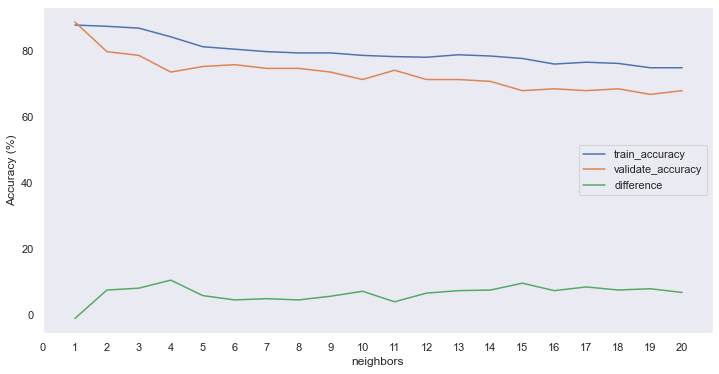

In [16]:
compare.set_index('neighbors').plot(figsize=(12,6))
plt.ylabel('Accuracy (%)')
plt.xticks(np.arange(0,21,1))
plt.grid()

# LOGISTIC REGRESSION

In [112]:
titanic = acquire.get_titanic_data()
#titanic = prepare.prep_titanic(titanic)
# train, val, test = prepare.split_data(titanic, 'survived')
titanic.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [113]:
titanic2 = titanic[['survived', 'pclass', 'sex','age','fare', 'alone']]
titanic2.sex = titanic2.sex.str.replace('female', '0').str.replace('male', '1').astype('int')
titanic2.head()

/var/folders/tg/htdzmdmj40vgs24scqz284xm0000gn/T/ipykernel_12409/3270131074.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic2.sex = titanic2.sex.str.replace('female', '0').str.replace('male', '1').astype('int')


,survived,pclass,sex,age,fare,alone
0,0,3,1,22.0,7.2500,0
1,1,1,0,38.0,71.2833,0
2,1,3,0,26.0,7.9250,1
3,1,1,0,35.0,53.1000,0
4,0,3,1,35.0,8.0500,1


In [114]:
train, val, test = prepare.split_data(titanic2, 'survived')
filler = train.age.median()

In [115]:
filler

27.0

In [116]:
baseline = train.survived.mode()
baseline_train = baseline.tolist()*train.shape[0]
baseline_val = baseline.tolist()*val.shape[0]
baseline_test = baseline.tolist()*test.shape[0]

In [117]:
train.age = train.age.fillna(value=filler)
val.age = val.age.fillna(value=filler)
test.age = test.age.fillna(value=filler)

In [118]:
y_train1 = train.survived
X_train1 = train.drop(columns=['survived', 'sex', 'alone'])
X_val1 = val.drop(columns=['survived', 'sex', 'alone'])
y_val1 = val.survived
X_test1 = test.drop(columns=['survived', 'sex', 'alone'])
y_test1 = test.survived

#### 1. Create a model that includes age in addition to fare and pclass. Does this model perform better than your baseline?

In [119]:
X_train1.head()

,pclass,age,fare
455,3,29.0,7.8958
380,1,42.0,227.5250
492,1,55.0,30.5000
55,1,27.0,35.5000
243,3,22.0,7.1250


In [120]:
logit1 = LogisticRegression()
logit1.fit(X_train1, y_train1)

LogisticRegression()

In [121]:
y_pred1 = logit1.predict(X_train1)

In [122]:
logit1.score(X_train1, y_train1)

0.7059925093632958

In [123]:
pd.DataFrame(met.classification_report(y_train1, y_pred1, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.713930,0.681818,0.705993,0.697874,0.701603
recall,0.872340,0.439024,0.705993,0.655682,0.705993
f1-score,0.785226,0.534125,0.705993,0.659675,0.688829
support,329.000000,205.000000,0.705993,534.000000,534.000000


In [124]:
pd.DataFrame(met.classification_report(y_train1, baseline_train, output_dict=True))

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,accuracy,macro avg,weighted avg
precision,0.616105,0.0,0.616105,0.308052,0.379585
recall,1.000000,0.0,0.616105,0.500000,0.616105
f1-score,0.762457,0.0,0.616105,0.381228,0.469753
support,329.000000,205.0,0.616105,534.000000,534.000000


#### 2. Include sex in your model as well. Note that you'll need to encode or create a dummy variable of this feature before including it in a model.

In [125]:
y_train2 = train.survived
X_train2 = train.drop(columns=['survived', 'alone'])
X_val2 = val.drop(columns=['survived','alone'])
y_val2 = val.survived
X_test2 = test.drop(columns=['survived', 'alone'])
y_test2 = test.survived

In [126]:
X_train2.head()

,pclass,sex,age,fare
455,3,1,29.0,7.8958
380,1,0,42.0,227.5250
492,1,1,55.0,30.5000
55,1,1,27.0,35.5000
243,3,1,22.0,7.1250


In [127]:
logit2 = LogisticRegression()
logit2.fit(X_train2, y_train2)
y_pred2 = logit2.predict(X_train2)

In [128]:
logit2.score(X_train2, y_train2)

0.797752808988764

#### 3. Try out other combinations of features and models.

In [129]:
y_train3 = train.survived
X_train3 = train.drop(columns=['survived', 'sex'])
X_val3 = val.drop(columns=['survived', 'sex'])
y_val3 = val.survived
X_test3 = test.drop(columns=['survived', 'sex'])
y_test3 = test.survived

In [130]:
X_train3.head()

,pclass,age,fare,alone
455,3,29.0,7.8958,1
380,1,42.0,227.5250,1
492,1,55.0,30.5000,1
55,1,27.0,35.5000,1
243,3,22.0,7.1250,1


In [131]:
logit3 = LogisticRegression()
logit3.fit(X_train3, y_train3)
y_pred3 = logit3.predict(X_train3)
logit3.score(X_train3, y_train3)

0.7097378277153558

In [132]:
y_train4 = train.survived
X_train4 = train.drop(columns=['survived', 'age'])
X_val4 = val.drop(columns=['survived', 'age'])
y_val4 = val.survived
X_test4 = test.drop(columns=['survived', 'age'])
y_test4 = test.survived

In [133]:
X_train4.head()

,pclass,sex,fare,alone
455,3,1,7.8958,1
380,1,0,227.5250,1
492,1,1,30.5000,1
55,1,1,35.5000,1
243,3,1,7.1250,1


In [134]:
logit4 = LogisticRegression()
logit4.fit(X_train4, y_train4)
y_pred4 = logit4.predict(X_train4)
logit4.score(X_train4, y_train4)

0.7921348314606742

In [135]:
y_train5 = train.survived
X_train5 = train.drop(columns=['survived', 'fare'])
X_val5 = val.drop(columns=['survived', 'fare'])
y_val5 = val.survived
X_test5 = test.drop(columns=['survived', 'fare'])
y_test5 = test.survived

In [136]:
X_train5.head()

,pclass,sex,age,alone
455,3,1,29.0,1
380,1,0,42.0,1
492,1,1,55.0,1
55,1,1,27.0,1
243,3,1,22.0,1


In [137]:
logit5 = LogisticRegression()
logit5.fit(X_train5, y_train5)
y_pred5 = logit5.predict(X_train5)
logit5.score(X_train5, y_train5)

0.7902621722846442

In [138]:
y_train6 = train.survived
X_train6 = train.drop(columns=['survived', 'age','alone'])
X_val6 = val.drop(columns=['survived', 'age','alone'])
y_val6 = val.survived
X_test6 = test.drop(columns=['survived', 'age','alone'])
y_test6 = test.survived

In [139]:
X_train6.head()

,pclass,sex,fare
455,3,1,7.8958
380,1,0,227.5250
492,1,1,30.5000
55,1,1,35.5000
243,3,1,7.1250


In [140]:
logit6 = LogisticRegression()
logit6.fit(X_train6, y_train6)
y_pred6 = logit6.predict(X_train6)
logit6.score(X_train6, y_train6)

0.7921348314606742

In [141]:
y_train7 = train.survived
X_train7 = train.drop(columns=['survived', 'fare','alone'])
X_val7 = val.drop(columns=['survived', 'fare','alone'])
y_val7 = val.survived
X_test7 = test.drop(columns=['survived', 'fare','alone'])
y_test7 = test.survived

In [142]:
X_train7.head()

,pclass,sex,age
455,3,1,29.0
380,1,0,42.0
492,1,1,55.0
55,1,1,27.0
243,3,1,22.0


In [143]:
logit7 = LogisticRegression()
logit7.fit(X_train7, y_train7)
y_pred7 = logit7.predict(X_train7)
logit7.score(X_train7, y_train7)

0.8014981273408239

#### 4. Use you best 3 models to predict and evaluate on your validate sample.

In [144]:
logit1.score(X_train1, y_train1),logit2.score(X_train2, y_train2),logit3.score(X_train3, y_train3),logit4.score(X_train4, y_train4),logit5.score(X_train5, y_train5),logit6.score(X_train6, y_train6),logit7.score(X_train7, y_train7)

(0.7059925093632958,
 0.797752808988764,
 0.7097378277153558,
 0.7921348314606742,
 0.7902621722846442,
 0.7921348314606742,
 0.8014981273408239)

#### 5. Choose you best model from the validation performation, and evaluate it on the test dataset. How do the performance metrics compare to validate? to train?

In [99]:
# models 2, 5, and 7 were the best with mean as null filler

models = {'logit2' : {'train_accuracy':logit2.score(X_train2, y_train2),
                      'val_accuracy':logit2.score(X_val2, y_val2),
                      'columns_dropped': 'alone',
                      'columns_kept': 'pclass, sex, age, fare'},
          'logit5' : {'train_accuracy':logit5.score(X_train5, y_train5),
                      'val_accuracy':logit5.score(X_val5, y_val5),
                      'columns_dropped': 'fare',
                      'columns_kept': 'pclass, sex, age, alone'},
          'logit7' : {'train_accuracy':logit7.score(X_train7, y_train7),
                      'val_accuracy':logit7.score(X_val7, y_val7),
                      'columns_dropped': 'fare, alone',
                      'columns_kept': 'pclass, sex, age'},
         }
    
pd.DataFrame(models).T

,train_accuracy,val_accuracy,columns_dropped,columns_kept
logit2,0.797753,0.786517,alone,"pclass, sex, age, fare"
logit5,0.790262,0.780899,fare,"pclass, sex, age, alone"
logit7,0.801498,0.780899,"fare, alone","pclass, sex, age"


In [100]:
best_model = {'logit7' : {'train_accuracy':logit7.score(X_train7, y_train7),
                          'val_accuracy':logit7.score(X_val7, y_val7),
                          'test_accuracy':logit7.score(X_test7, y_test7),
                          'columns_dropped': 'fare, alone',
                          'columns_kept': 'pclass, sex, age'}
             }
pd.DataFrame(best_model).T

,columns_dropped,columns_kept,test_accuracy,train_accuracy,val_accuracy
logit7,"fare, alone","pclass, sex, age",0.798883,0.801498,0.780899


#### BONUS 1

In [ ]:
# models 2, 5, and 7 were the best with mean as null filler
# see above problem

In [145]:
logit1.score(X_train1, y_train1),logit2.score(X_train2, y_train2),logit3.score(X_train3, y_train3),logit4.score(X_train4, y_train4),logit5.score(X_train5, y_train5),logit6.score(X_train6, y_train6),logit7.score(X_train7, y_train7)

(0.7059925093632958,
 0.797752808988764,
 0.7097378277153558,
 0.7921348314606742,
 0.7902621722846442,
 0.7921348314606742,
 0.8014981273408239)

In [146]:
# models 2, 6, and 7 were the best with median as null filler

models = {'logit2' : {'train_accuracy':logit2.score(X_train2, y_train2),
                      'val_accuracy':logit2.score(X_val2, y_val2),
                      'columns_dropped': 'alone',
                      'columns_kept': 'pclass, sex, age, fare'},
          'logit6' : {'train_accuracy':logit6.score(X_train6, y_train6),
                      'val_accuracy':logit6.score(X_val6, y_val6),
                      'columns_dropped': 'fare',
                      'columns_kept': 'pclass, sex, age, alone'},
          'logit7' : {'train_accuracy':logit7.score(X_train7, y_train7),
                      'val_accuracy':logit7.score(X_val7, y_val7),
                      'columns_dropped': 'fare, alone',
                      'columns_kept': 'pclass, sex, age'},
         }
    
pd.DataFrame(models).T

,train_accuracy,val_accuracy,columns_dropped,columns_kept
logit2,0.797753,0.786517,alone,"pclass, sex, age, fare"
logit6,0.792135,0.775281,fare,"pclass, sex, age, alone"
logit7,0.801498,0.780899,"fare, alone","pclass, sex, age"


In [147]:
best_model = {'logit7' : {'train_accuracy':logit7.score(X_train7, y_train7),
                          'val_accuracy':logit7.score(X_val7, y_val7),
                          'test_accuracy':logit7.score(X_test7, y_test7),
                          'columns_dropped': 'fare, alone',
                          'columns_kept': 'pclass, sex, age'}
             }
pd.DataFrame(best_model).T

,columns_dropped,columns_kept,test_accuracy,train_accuracy,val_accuracy
logit7,"fare, alone","pclass, sex, age",0.798883,0.801498,0.780899
